In [138]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import tensor

In [189]:
"""
Define 1D configurations of atoms.
These will be displacements of a 1D chain, where the equilibrium distance is "1".
"""
natoms = 32
nconfigs = 1000
rc = 1.5

# Define indices upon which to contract per-atom energies
indices = []
for m in range(0,nconfigs):
    for i in range(0,natoms):
        indices.append(m)
indices = torch.tensor(indices, dtype=torch.int64)
print(indices)

# Descriptor params
dparams = [[0.1,0.5],
           [0.1,2.0],
           [0.01,0.01],
           [0.01,0.1],
           [0.01,0.15],
           [0.01,0.2],
           [0.2,3.0],
           [0.3,4.0]]
dparams = np.array(dparams)
nd = np.shape(dparams)[0]

# Torch params
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Box sizes
x_size = float(natoms)
x_rsize = 1.0 / x_size;

x0 = []
for i in range(0,natoms):
    x0.append(float(i))
x0 = np.array(x0)
#print(x0)

# Define all configs
x_all = [x0]
for m in range(0,nconfigs-1):
    x_tmp = []
    for i in range(0,natoms):
        x_tmp.append(np.random.normal(loc=x0[i],scale=0.1*1))
    x_all.append(x_tmp)
x_all =  np.array(x_all)

print(x_all)

tensor([  0,   0,   0,  ..., 999, 999, 999])
[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00 ...  2.90000000e+01
   3.00000000e+01  3.10000000e+01]
 [-2.48623297e-01  9.57147513e-01  1.90031324e+00 ...  2.91477183e+01
   2.99863323e+01  3.09723067e+01]
 [ 2.40394274e-02  9.55878254e-01  1.82260966e+00 ...  2.89200680e+01
   3.00323566e+01  3.08759575e+01]
 ...
 [-1.27801076e-01  8.00189422e-01  1.97397278e+00 ...  2.88549866e+01
   2.98800630e+01  3.09776305e+01]
 [ 1.75744688e-02  9.07988591e-01  1.92017193e+00 ...  2.90212159e+01
   2.99659694e+01  3.09422895e+01]
 [-9.72848612e-03  9.80937011e-01  2.01964727e+00 ...  2.90757289e+01
   2.99563787e+01  3.09502243e+01]]


In [190]:
"""
Define a neighborlist calculator.
Maybe not necessary?
"""


'\nDefine a neighborlist calculator.\nMaybe not necessary?\n'

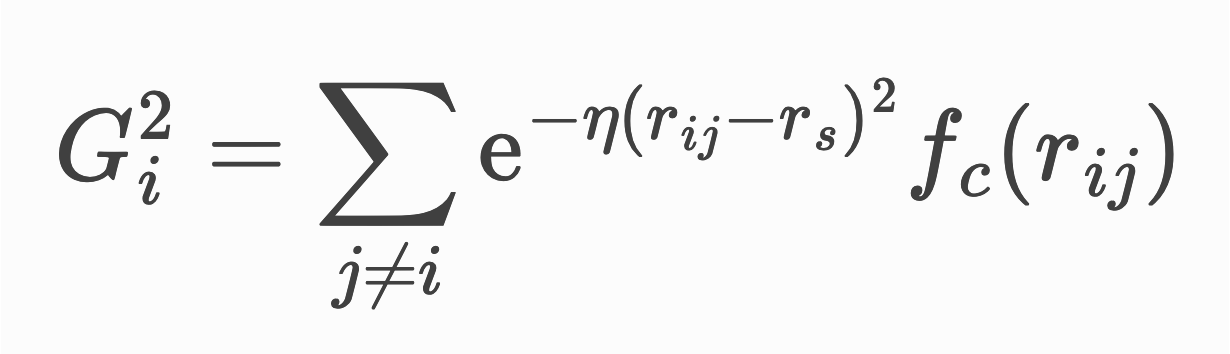
BP descriptors are calculated below.

In [191]:
"""
Define descriptors.
Input: x - positions of atoms in config.
Returns list of descriptors for all atoms in the config.
(natoms,nd)
"""
def fc(rij):
    value = 0.5*(np.cos((np.pi*rij)/rc) + 1)
    """
    if (rij<rc):
        value = 0.5*(np.cos((np.pi*rij)/rc) + 1)
    elif (rij>=rc):
        value = 0.0
    """
    return value

def calc_descriptors(x):
    d = np.zeros([natoms,nd]) # Allocate descriptors for this config
    
    for i in range(0,natoms):
        d_tmp = 0.0
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                #print(f'{i} {j} {xij}')
                rij = abs(xij)
                if (rij<1.5):
                    #print(f' {i} {j} {rij}')
                    for k in range(0,nd):
                        eta = dparams[k,0]
                        rs = dparams[k,1]
                        d[i,k] += np.exp(-1.0*eta*(rij-rs)**2)*fc(rij)
    return d
                    
                    
    #for k in range(0,nd):
        
    
    

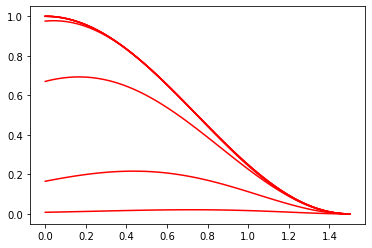

In [192]:
"""
Plot descriptors.
Visualize what the descriptors look like.
"""
def visualize_descriptors():
    rij = np.linspace(0,rc,100)
    functions = []
    #print(fc(rij))
    for k in range(0,nd):
        d_tmp = np.exp(-1.0*dparams[k,0]*(rij-dparams[k,1])**2)*fc(rij)
        #d_tmp = fc(rij)
        #functions.append(np.exp(dparams[k,0]*(rij-dparams[k,1])**2))
        #functions.append(d_tmp)
        plt.plot(rij, d_tmp, 'r')
    #functions = np.array(functions)
    plt.show()
    #print(functions)
visualize_descriptors()

In [193]:
"""
Define the 2-body potential
Input: x - positions of atoms in config.
Return forces and energy for a single config.
"""
def potential(x):
    etot = 0.
    for i in range(0,natoms):
        ei = 0.0
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                #print(f'{i} {j} {xij}')
                rij = abs(xij)
                if (rij<1.5):
                    #print(f' {i} {j} {rij}')
                    ei += (rij-1.)**2
        etot += ei
        
    return etot

In [194]:
"""
Loop through all configs and calculate energy and descriptors.
"""
targets = torch.zeros(nconfigs)
#descriptors = torch.zeros([nconfigs*natoms,nd])
descriptors = []
for m in range(0,nconfigs):
    #config = x_all[m,:]
    pe = potential(x_all[m,:])
    print(pe)
    targets[m] = pe
    d_tmp = calc_descriptors(x_all[m,:])
    descriptors.append(d_tmp)
print(targets)
descriptors = np.array(descriptors)
print(np.shape(descriptors))
descriptors = np.concatenate(descriptors,axis=0)
print(np.shape(descriptors))
descriptors = torch.from_numpy(descriptors).float()
print(descriptors)

0.0
0.7757851414214905
1.151992900844934
1.288283652919703
0.6829740685604303
0.6918972803856495
1.8444065221447583
1.1585421833522054
1.5821609752586026
0.935344553786384
0.7454675836434103
1.6050248581914703
2.356128180154
1.2964326436316203
1.0164401853902858
1.2219533376456155
0.7977863492041789
1.1333703282046153
1.4452389135965555
0.7207616548035018
1.4645351973310832
0.9360963633532442
1.272840709078347
1.001678971164583
1.819870203636165
0.9814686551434422
1.118272786602376
0.9350555102913714
0.9265676252429917
0.6835041589797818
0.6836432595108279
0.8433202767512427
1.189639034123928
0.7354927524825102
0.9222254946522846
1.32795062513971
1.949071071364144
1.8995832596606694
0.8356225260612823
0.914437787499191
1.0574720731902145
0.9488716990878369
0.9698620161971837
1.0901513948045864
0.8150076548563986
0.9040978658446177
1.3906274731998591
0.9542839043108242
0.7440385918536261
1.592983048566859
2.213775537453446
1.3116034552665048
1.554724414611179
1.456786158051515
1.2156678

1.1508771425760222
0.6916239243812929
0.8744344521817041
1.0289028357133125
1.0880152891988066
1.0773829865883084
1.7948408677816987
1.2473559981317042
0.8888948262767012
1.5829020485445098
1.1139652447509005
1.7283515598166663
0.796790108493152
1.2808877002472967
1.3514808066506567
0.9365081951820737
1.3064935314224975
0.9207513783149937
1.9095075267929644
0.7463706608461589
0.958866131858128
1.2646246663286487
0.8718763637292258
1.553949211031593
1.1263895706850824
1.2415699405710108
1.529780250465946
1.4878503510369474
0.8034202968741023
1.2097732678577162
0.9153710758102734
1.4196231977876417
1.3983735096718717
1.0582866719390025
0.7931520162273982
1.0798874897748292
1.1699027555578045
1.4854049327627599
2.7714083783364036
0.7671971764908952
2.105975868059093
1.4243367983677944
1.5226267202781398
1.3392713801300902
1.0079410474117976
1.0913106945503535
1.1438213316208243
1.0870931670667352
2.123129470592259
1.766187140365271
1.0525345744969066
0.7700062544329866
0.9138427639401379


1.2818362792918763
0.9496992897962517
1.8803618106639148
1.5639090774808104
1.1356973589262729
0.6576459828333742
1.5785877006854556
1.6875430893505046
2.000885654625307
1.418037381505969
1.652482811494067
1.1161158959958388
1.3338849060299667
1.1105488128022065
1.0440882134684095
1.2825132493107343
1.4020849720094963
0.9943712758519233
1.4474542376889352
0.934393386687033
0.8682840913242117
1.1541244725090738
0.8152262332020963
tensor([0.0000, 0.7758, 1.1520, 1.2883, 0.6830, 0.6919, 1.8444, 1.1585, 1.5822,
        0.9353, 0.7455, 1.6050, 2.3561, 1.2964, 1.0164, 1.2220, 0.7978, 1.1334,
        1.4452, 0.7208, 1.4645, 0.9361, 1.2728, 1.0017, 1.8199, 0.9815, 1.1183,
        0.9351, 0.9266, 0.6835, 0.6836, 0.8433, 1.1896, 0.7355, 0.9222, 1.3280,
        1.9491, 1.8996, 0.8356, 0.9144, 1.0575, 0.9489, 0.9699, 1.0902, 0.8150,
        0.9041, 1.3906, 0.9543, 0.7440, 1.5930, 2.2138, 1.3116, 1.5547, 1.4568,
        1.2157, 0.8346, 0.5882, 1.7872, 1.1964, 1.3849, 1.6826, 1.8544, 1.7859,
       

In [195]:
"""
Loop through all configs and calculate descriptors
"""


'\nLoop through all configs and calculate descriptors\n'

In [196]:
"""
Define training data.
Should be shape (nconfigs*natoms,ndescriptors)
"""


'\nDefine training data.\nShould be shape (nconfigs*natoms,ndescriptors)\n'

In [197]:
"""
Define the network parameters
"""
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
layer_sizes = [nd, 10, 1]


In [198]:
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    ADR: No I don't think it standardizes anything...
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:
        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
    except IndexError:
        layers.pop()
    return torch.nn.Sequential(*layers)

network_architecture = create_torch_network(layer_sizes)
print(network_architecture)
for name, param in network_architecture.named_parameters():
    print(name)
    print(param)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=10, bias=True)
  (2): Softplus(beta=1, threshold=20)
  (3): Linear(in_features=10, out_features=1, bias=True)
)
0.weight
Parameter containing:
tensor([[-0.2369, -0.0454, -0.2713,  0.2189, -0.0125,  0.0813,  0.2754,  0.3000],
        [-0.1525,  0.3279, -0.0678,  0.2492, -0.1307,  0.1411, -0.2116,  0.0528],
        [ 0.0274, -0.0342,  0.2832, -0.1419, -0.2360,  0.2818,  0.1670,  0.2835],
        [ 0.2257,  0.0685,  0.2465,  0.0219, -0.2812, -0.0533,  0.0894,  0.3435],
        [-0.3236,  0.2000,  0.1919,  0.2886, -0.0321,  0.3203,  0.1963,  0.1477],
        [ 0.0824,  0.1809, -0.3369, -0.0370,  0.0036,  0.1392, -0.0962, -0.1705],
        [ 0.1033, -0.3291, -0.0817,  0.1383, -0.3114, -0.0568,  0.0350,  0.1723],
        [-0.2700, -0.0471,  0.2174, -0.1843,  0.1057, -0.1530, -0.2171, -0.0603]],
       requires_grad=True)
0.bias
Parameter containing:
tensor([-0.2388,  0.2544, -0.3316,

In [199]:
"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements
        
    def forward(self, x, indices, atoms_per_structure):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """

        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())
        return predicted_energy_total

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)

In [210]:
"""
Create the model.
"""
model = FitTorch(network_architecture, nd)
print(model)
#print(model.network_architecture,0,weight)

FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=10, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [211]:
"""
Define energy calculation parameters
"""
num_atoms = 8*torch.ones(nconfigs,dtype=torch.int32) # number of atoms per config
print(descriptors)
print(indices)
print(type(num_atoms))
test = model(descriptors, indices, num_atoms)
#print(test)
energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
print(energies)

tensor([[0.4877, 0.4524, 0.4951,  ..., 0.4968, 0.2247, 0.0336],
        [0.4877, 0.4524, 0.4951,  ..., 0.4968, 0.2247, 0.0336],
        [0.4877, 0.4524, 0.4951,  ..., 0.4968, 0.2247, 0.0336],
        ...,
        [0.4933, 0.4510, 0.4995,  ..., 0.5011, 0.2180, 0.0316],
        [0.6091, 0.5529, 0.6153,  ..., 0.6172, 0.2629, 0.0367],
        [0.4579, 0.4267, 0.4655,  ..., 0.4671, 0.2138, 0.0325]])
tensor([  0,   0,   0,  ..., 999, 999, 999])
<class 'torch.Tensor'>
tensor([-0.1408,  6.0236,  8.7054,  9.8784,  5.1752,  5.2208, 11.3430,  8.8310,
        12.2254,  7.0131,  5.6185, 12.3083, 15.6743,  9.9669,  7.6608,  9.6172,
         6.1286,  8.6172, 10.9519,  5.5999, 11.2260,  7.3264,  9.7423,  7.5163,
        11.2507,  7.3941,  8.4146,  7.1330,  7.1925,  5.1675,  5.1124,  6.4484,
         9.1940,  5.7346,  6.9094, 10.1784, 15.0943, 14.7004,  6.2980,  6.9960,
         8.2147,  7.2549,  7.3735,  8.3911,  6.1864,  7.2254, 10.7327,  7.1599,
         5.6307, 12.2747, 16.7151, 10.0670, 11.8778, 1

In [212]:
"""
Define training objects
"""
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


In [214]:
"""
Train
"""
for epoch in range(1000):
    energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
    loss = loss_function(energies/num_atoms, targets)
    if (epoch % 1 == 0):
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 1, loss = 0.0025
epoch: 2, loss = 0.0025
epoch: 3, loss = 0.0025
epoch: 4, loss = 0.0025
epoch: 5, loss = 0.0025
epoch: 6, loss = 0.0025
epoch: 7, loss = 0.0025
epoch: 8, loss = 0.0025
epoch: 9, loss = 0.0025
epoch: 10, loss = 0.0025
epoch: 11, loss = 0.0025
epoch: 12, loss = 0.0025
epoch: 13, loss = 0.0025
epoch: 14, loss = 0.0025
epoch: 15, loss = 0.0025
epoch: 16, loss = 0.0025
epoch: 17, loss = 0.0025
epoch: 18, loss = 0.0025
epoch: 19, loss = 0.0025
epoch: 20, loss = 0.0025
epoch: 21, loss = 0.0025
epoch: 22, loss = 0.0025
epoch: 23, loss = 0.0025
epoch: 24, loss = 0.0025
epoch: 25, loss = 0.0025
epoch: 26, loss = 0.0025
epoch: 27, loss = 0.0025
epoch: 28, loss = 0.0025
epoch: 29, loss = 0.0025
epoch: 30, loss = 0.0025
epoch: 31, loss = 0.0025
epoch: 32, loss = 0.0025
epoch: 33, loss = 0.0025
epoch: 34, loss = 0.0025
epoch: 35, loss = 0.0025
epoch: 36, loss = 0.0025
epoch: 37, loss = 0.0025
epoch: 38, loss = 0.0025
epoch: 39, loss = 0.0025
epoch: 40, loss = 0.0025
epoch: 41

epoch: 353, loss = 0.0025
epoch: 354, loss = 0.0025
epoch: 355, loss = 0.0025
epoch: 356, loss = 0.0025
epoch: 357, loss = 0.0025
epoch: 358, loss = 0.0025
epoch: 359, loss = 0.0025
epoch: 360, loss = 0.0025
epoch: 361, loss = 0.0025
epoch: 362, loss = 0.0025
epoch: 363, loss = 0.0025
epoch: 364, loss = 0.0025
epoch: 365, loss = 0.0025
epoch: 366, loss = 0.0025
epoch: 367, loss = 0.0025
epoch: 368, loss = 0.0025
epoch: 369, loss = 0.0025
epoch: 370, loss = 0.0025
epoch: 371, loss = 0.0025
epoch: 372, loss = 0.0025
epoch: 373, loss = 0.0025
epoch: 374, loss = 0.0025
epoch: 375, loss = 0.0025
epoch: 376, loss = 0.0025
epoch: 377, loss = 0.0025
epoch: 378, loss = 0.0025
epoch: 379, loss = 0.0025
epoch: 380, loss = 0.0025
epoch: 381, loss = 0.0025
epoch: 382, loss = 0.0025
epoch: 383, loss = 0.0025
epoch: 384, loss = 0.0025
epoch: 385, loss = 0.0025
epoch: 386, loss = 0.0025
epoch: 387, loss = 0.0025
epoch: 388, loss = 0.0025
epoch: 389, loss = 0.0025
epoch: 390, loss = 0.0025
epoch: 391, 

epoch: 696, loss = 0.0025
epoch: 697, loss = 0.0025
epoch: 698, loss = 0.0025
epoch: 699, loss = 0.0025
epoch: 700, loss = 0.0025
epoch: 701, loss = 0.0025
epoch: 702, loss = 0.0025
epoch: 703, loss = 0.0025
epoch: 704, loss = 0.0025
epoch: 705, loss = 0.0025
epoch: 706, loss = 0.0025
epoch: 707, loss = 0.0025
epoch: 708, loss = 0.0025
epoch: 709, loss = 0.0025
epoch: 710, loss = 0.0025
epoch: 711, loss = 0.0025
epoch: 712, loss = 0.0025
epoch: 713, loss = 0.0025
epoch: 714, loss = 0.0025
epoch: 715, loss = 0.0025
epoch: 716, loss = 0.0025
epoch: 717, loss = 0.0025
epoch: 718, loss = 0.0025
epoch: 719, loss = 0.0025
epoch: 720, loss = 0.0025
epoch: 721, loss = 0.0025
epoch: 722, loss = 0.0025
epoch: 723, loss = 0.0025
epoch: 724, loss = 0.0025
epoch: 725, loss = 0.0025
epoch: 726, loss = 0.0025
epoch: 727, loss = 0.0025
epoch: 728, loss = 0.0025
epoch: 729, loss = 0.0025
epoch: 730, loss = 0.0025
epoch: 731, loss = 0.0025
epoch: 732, loss = 0.0025
epoch: 733, loss = 0.0025
epoch: 734, 

In [218]:
#print(energies/num_atoms)
#print(targets)

tensor([0.0203, 0.7976, 1.1413, 1.2893, 0.6914, 0.6984, 1.4731, 1.1571, 1.5855,
        0.9273, 0.7484, 1.5991, 2.0214, 1.2992, 1.0089, 1.2537, 0.8123, 1.1292,
        1.4280, 0.7458, 1.4602, 0.9640, 1.2727, 0.9903, 1.4573, 0.9748, 1.1038,
        0.9405, 0.9478, 0.6914, 0.6851, 0.8536, 1.2035, 0.7622, 0.9146, 1.3285,
        1.9516, 1.9014, 0.8364, 0.9219, 1.0771, 0.9553, 0.9722, 1.0992, 0.8202,
        0.9486, 1.3966, 0.9461, 0.7507, 1.5932, 2.1633, 1.3147, 1.5439, 1.4530,
        1.2210, 0.8200, 0.6132, 1.8090, 1.1999, 1.3820, 1.6639, 1.8806, 1.7896,
        1.3215, 2.0610, 1.7054, 1.4116, 2.0883, 1.5582, 0.6607, 0.9814, 1.5945,
        1.0417, 1.4826, 0.9863, 1.0786, 1.3532, 1.3479, 1.1864, 1.2729, 1.3887,
        1.1159, 1.4131, 1.9456, 1.1660, 1.6030, 0.9573, 0.9683, 0.9085, 1.7708,
        2.1430, 1.1106, 1.2957, 1.8555, 1.4700, 0.8324, 0.9580, 1.3883, 1.4418,
        1.2724, 2.3479, 0.7654, 0.9550, 0.9592, 1.4704, 1.7828, 0.8957, 1.4932,
        1.0242, 0.7762, 1.8608, 1.4047, 

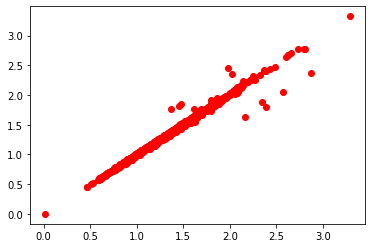

In [222]:
# Plot
predicted = model(descriptors,indices,num_atoms).detach().numpy()

plt.plot(predicted/num_atoms, targets.numpy(), 'ro')
plt.show()